In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
print(tf.__version__ )
print(sys.version_info)

for module in mpl, np,pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()

x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(np.max(x_train),np.max(x_valid),np.max(x_test))

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)
255 255 255


In [3]:
# x = (x-u)/std
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

print(np.max(x_train_scaled),np.max(x_valid_scaled),np.max(x_test_scaled))

2.023144 2.023144 2.023144


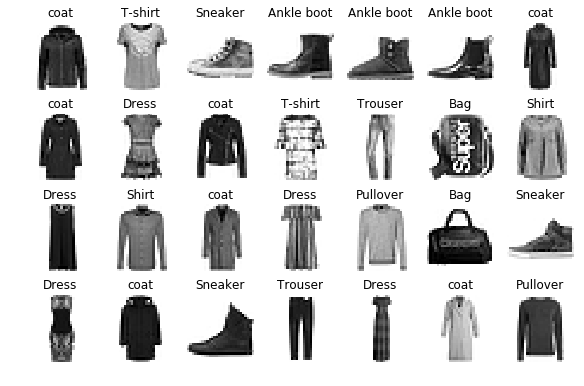

In [4]:
def show_single_image(img_arr):
    plt.imshow(img_arr,cmap="binary")
    plt.show()

def show_imgs(n_rows,n_cols,x_data,y_data, classNames):
    assert len(x_data)== len(y_data)
    assert n_rows*n_cols < len(x_data)
    plt.figure(figsize=(n_cols*1.4,n_rows*1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = row*n_cols+col
            plt.subplot(n_rows,n_cols, index+1)
            plt.imshow(x_data[index],cmap="binary",interpolation="nearest")
            plt.axis('off')
            plt.title(classNames[y_data[index]])
    plt.show()

class_names = ['T-shirt','Trouser','Pullover','Dress','coat','Sandal','Shirt',
               'Sneaker','Bag','Ankle boot']
show_imgs(4,7,x_train,y_train,class_names)

In [5]:
#tf.keras.models.senquential
#建立senquential 模型方式一

# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[28,28]))
# model.add(keras.layers.Dense(300,activation="relu")) #全联接层
# model.add(keras.layers.Dense(200,activation="relu"))
# model.add(keras.layers.Dense(10,activation="softmax"))
#relu = max(0,x)

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28,28]),#将矩阵flat
#     keras.layers.Dense(300,activation="relu"),#全联接层
#     keras.layers.Dense(100,activation="relu"),
#     keras.layers.Dense(10,activation="softmax")
# ])


model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation="relu"))
    model.add(keras.layers.BatchNormalization())    #批归一化在激活函数之后
    
    
    """
    #批归一化在激活函数之前
    model.add(keras.layers.Dense(100))              #添加全链接层
    model.add(keras.layers.BatchNormalization())    #批归一化
    model.add(keras.layers.Activation("relu"))      #添加激活函数
    """
model.add(keras.layers.Dense(10,activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", #sparse 的交叉损失熵
             optimizer="adam",
             metrics = ["accuracy"])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [7]:
#Tensorboard, earlystopping, ModelCheckpoint
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
output_model_file = os.path.join(logdir,
                                "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3), #连续5次损失函数和上一次差距小于1e-3即可停止训练    
]
his = model.fit(x_train,y_train,epochs=10, 
         validation_data=(x_valid,y_valid),
                 callbacks = callbacks)  #epochs 训练次数
#终端命令 tensorboard --logdir=callbacks 

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 18s 325us/sample - loss: 1.1286 - accuracy: 0.6004 - val_loss: 0.6582 - val_accuracy: 0.7768
Epoch 2/10
55000/55000 [==============================] - 14s 250us/sample - loss: 0.7147 - accuracy: 0.7492 - val_loss: 0.5351 - val_accuracy: 0.8158
Epoch 3/10
55000/55000 [==============================] - 14s 247us/sample - loss: 0.6155 - accuracy: 0.7895 - val_loss: 0.5529 - val_accuracy: 0.8122
Epoch 4/10
55000/55000 [==============================] - 15s 268us/sample - loss: 0.5810 - accuracy: 0.8020 - val_loss: 0.5660 - val_accuracy: 0.8182
Epoch 5/10
55000/55000 [==============================] - 15s 278us/sample - loss: 0.5639 - accuracy: 0.8076 - val_loss: 0.4950 - val_accuracy: 0.8214
Epoch 6/10
55000/55000 [==============================] - 14s 255us/sample - loss: 0.5312 - accuracy: 0.8194 - val_loss: 0.6605 - val_accuracy: 0.8202
Epoch 7/10
55000/55000 [=====================

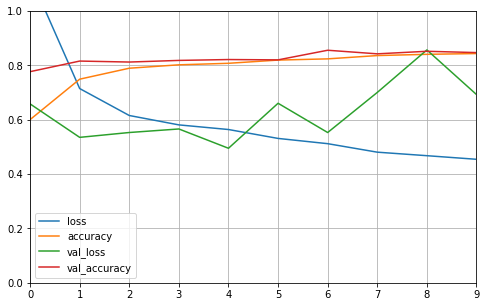

In [8]:
 def plot_learning_curves(his):
        pd.DataFrame(his.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        
plot_learning_curves(his)